In [6]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


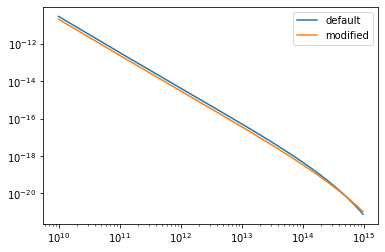

In [3]:
import hmf
import numpy as np
import matplotlib.pyplot as pl
from hmf.transfer_models import TransferComponent

# Create an hmf.MassFunction instance to work with
MF1 = hmf.MassFunction()

# Hack out the transfer function (will be default from CAMB)
k = MF1.k
T = MF1.transfer_function


class MyTransferModel(TransferComponent):
    """
    My awesome transfer function.
    """

    # Some modulation factor (place-holder for actual parameters).
    _defaults = {"fmod": 1.0}

    def lnt(self, lnk):
        """
        Natural log of the transfer function.

        Parameters
        ----------
        lnk : array_like
            Wavenumbers [Mpc/h]

        Returns
        -------
        lnt : array_like
            The log of the transfer function at lnk.
        
        """
        return np.interp(lnk, np.log(k), np.log(T * self.params["fmod"]))


# Put in some made-up modulation factor, fmod, to make sure things are working.
transfer_kwargs = {"fmod": np.ones_like(k) * (k / 1.0) ** -0.2}

MF2 = hmf.MassFunction(
    transfer_model=MyTransferModel,
    filter_model=hmf.filters.TopHat,
    transfer_params=transfer_kwargs,
)

MF1.update(z=0)
MF2.update(z=0)

pl.loglog(MF1.m, MF1.dndm, label=r"default")
pl.loglog(MF2.m, MF2.dndm, label=r"modified")
pl.legend()

In [5]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import hmf
from hmf.transfer_models import TransferComponent
from cobaya.theory import Theory
from cobaya.likelihood import Likelihood


class ExplicitTransferModel(TransferComponent):
    def __init__(self, lnt_interpolator):
        self.lnt_interpolator = lnt_interpolator

    def lnt(self, lnk):
        return self.lnt_interpolator(lnk)


class HMF(Theory):
    def initialize(self):
        self.z = np.arange(0, 2, 0.05)
        self.k = np.logspace(-4, np.log10(5), 200)
        self.lnk = np.log(self.k)
        self.filter_model = hmf.filters.TopHat

    def initialize_with_provider(self, provider):
        """
        Initialization after other components initialized, using Provider class
        instance which is used to return any dependencies.
        """
        self.provider = provider
        self.hmf = None

    def get_requirements(self):
        """Things needed from other components
        
        This is borrowed from SO clusters likelihood.
        
        Do we need anything else?
        """
        return {
            "CAMB_transfers": {},
            "Pk_interpolator": {
                "z": self.zarr,
                "k_max": 5.0,
                "nonlinear": False,
                "hubble_units": False,  # cobaya told me to
                "k_hunit": False,  # cobaya told me to
                "vars_pairs": [["delta_nonu", "delta_nonu"]],
            },
            "Hubble": {"z": self.zarr},
            "angular_diameter_distance": {"z": self.zarr},
        }

    def _set_hmf(self):

        camb_transfers = self.provider.get_CAMB_transfers()
        T = camb_transfers.get_matter_transfer_data().transfer_data
        T = np.log(T[[0, 6], :, 0])

        if lnk[0] < T[0, 0]:
            lnkout, lnT = self._check_low_k(T[0, :], T[1, :], lnk[0])
        else:
            lnkout = T[0, :]
            lnT = T[1, :]

        lnt_interpolator = spline(lnkout, lnT, k=1)
        transfer_kwargs = {"lnt_interpolator": lnt_interpolator}
        self.hmf = hmf.MassFunction(
            transfer_model=ExplicitTransferModel,
            filter_model=hmf.filters.TopHat,
            transfer_params=transfer_kwargs,
        )        

    def get_dn_dm(self, z=0):
        self.hmf.update(z=z)
        return self.hmf.dndm
        
    def get_dn_dzdm_interpolator(self):
        """Object to evaluate dndm at any (z, m)
        """

    def calculate(self, state, want_derived=True, **params_values_dict):
        self._set_hmf()
        state["hmf"] = ...
        state["dn_dzdm_interpolator"] = ...
        

class DummyLike(Likelihood):
    def get_requirements(self):
        return {'dn_dm': {}}
    
    def lnlike(self, **params):
        dndm = self.provider.get_dn_dm()
        return dndm.sum()
    